In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
import random


In [2]:
import seaborn as sns
sns.set_theme()

# 生成并划分随机数据

In [21]:
# import numpy as np
# import pandas as pd
# import math
# import random
# import matplotlib.pyplot as plt
# # 生成四列正态分布的数据
# point1 = abs(np.random.normal(1, 12, 10000))
# point2 = abs(np.random.normal(2,50, 10000))
# point3 = abs(np.random.normal(3, 0.6, 10000))
# point4 = abs(np.random.normal(5, 5, 10000))
# # 将4列数据进行拼接
# x = np.c_[point1, point2, point3, point4]
# print(x)
# # 定义分类特征y为0或1
# y = [int(np.random.randint(0, 2)) for i in range(10000)]
# print(y)
# data = pd.DataFrame()
# data['col1'] = point1
# data['col2'] = point2
# data['col3'] = point3
# data['col4'] = point4
# data['out']=y
# print(data)
# #画出每一维x和y的分布关系
# plt.subplot(2, 2, 1)
# plt.title('col1')
# plt.scatter(y, point1, color ='r', label ='col1')
# plt.subplot(2, 2, 2)
# plt.title('Col2')
# plt.scatter(y, point2, color = 'g', label ='col2')
# plt.subplot(2, 2, 3)
# plt.title('Col3')
# plt.scatter(y, point3, color ='b', label ='col3')
# plt.subplot(2, 2, 4)
# plt.title('Col4')
# plt.scatter(y, point4, color ='y', label ='col4')
# # 保存图片
# plt.savefig('data_visualization.jpg')
# # displaying
# plt.show()


In [72]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
x, y = make_classification(n_samples=20000, n_classes=4, n_informative=5,n_features=10)
# plt.scatter(cla_x, cla_y, c=label)
# plt.show()
print(x.shape[1])
print(x)
print(y)

10
[[ 0.4373618   1.31076866  0.99149708 ... -0.00681409  1.42543481
  -1.60665307]
 [-0.92143428 -0.44977084  1.67211283 ... -0.76060298 -3.40855178
   1.69696254]
 [ 0.40664787 -1.59367659 -0.72630854 ...  1.61924559 -2.74485261
   2.44243615]
 ...
 [ 0.43198902 -2.20079729 -0.293073   ...  1.14551044 -1.89173698
   0.11993767]
 [ 0.78389332  4.43333277 -2.14373381 ... -1.95644605 -0.7102483
   0.3864418 ]
 [ 0.15427959  2.66804285  0.15361852 ... -1.9894874   0.80200626
   1.14801829]]
[1 3 3 ... 3 1 3]


In [73]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print('train shape',X_train.shape)
print('test shape',X_test.shape)

train shape (14000, 10)
test shape (6000, 10)


# 训练集RSP划分

In [74]:
def data2HDFS_RSP(data, K=65, M=20):
    ''''' 
    先按HDFS数据块划分，再划分为RSP数据块 
    K: HDFS 个数
    M: RSP个数
    '''  
    global HDFS, RSP
    try:
        global HDFS, RSP
        # 按顺序切分为k份 
        HDFS=np.array(np.split(data,K))  
        for i in range(HDFS.shape[0]):  
            np.random.shuffle(HDFS[i])  
        HDFS_list=[np.split(D_k,M) for D_k in HDFS]  
        # 划分RSP 
        RSP=[[D_K[m] for D_K in HDFS_list] for m in range(M)]  
        for idx,RSP_ in enumerate(RSP):  
            tmp_RSP=RSP_[0]  
            for i in range(1,len(RSP_)):  
                tmp_RSP=np.vstack((tmp_RSP,RSP_[i]))  
            RSP[idx]=tmp_RSP  
        RSP=np.array(RSP)  
    except:
        warnings.warn("wrong dimension of K and M")
    return (HDFS, RSP)

# 划分训练集
X_train=np.array(X_train)
y_train=np.array(y_train)

data_train = np.hstack([X_train, y_train[:,np.newaxis]])[:10000, :]
HDFS, RSP = data2HDFS_RSP(data_train, K=50, M=20)
print('HDFS: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(  
    HDFS.shape[0],HDFS.shape[1],HDFS.shape[2]))  
print('RSP: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(  
    RSP.shape[0],RSP.shape[1],RSP.shape[2]))  


HDFS: [块数: 50 块内元素个数: 200 数据块维度: 11]
RSP: [块数: 20 块内元素个数: 500 数据块维度: 11]


In [75]:
HDFS_list = [(HDFS[i,:,:-1],HDFS[i,:,-1]) for i in range(HDFS.shape[0])]

In [76]:
RSP_list = [(RSP[i,:,:-1],RSP[i,:,-1]) for i in range(RSP.shape[0])]

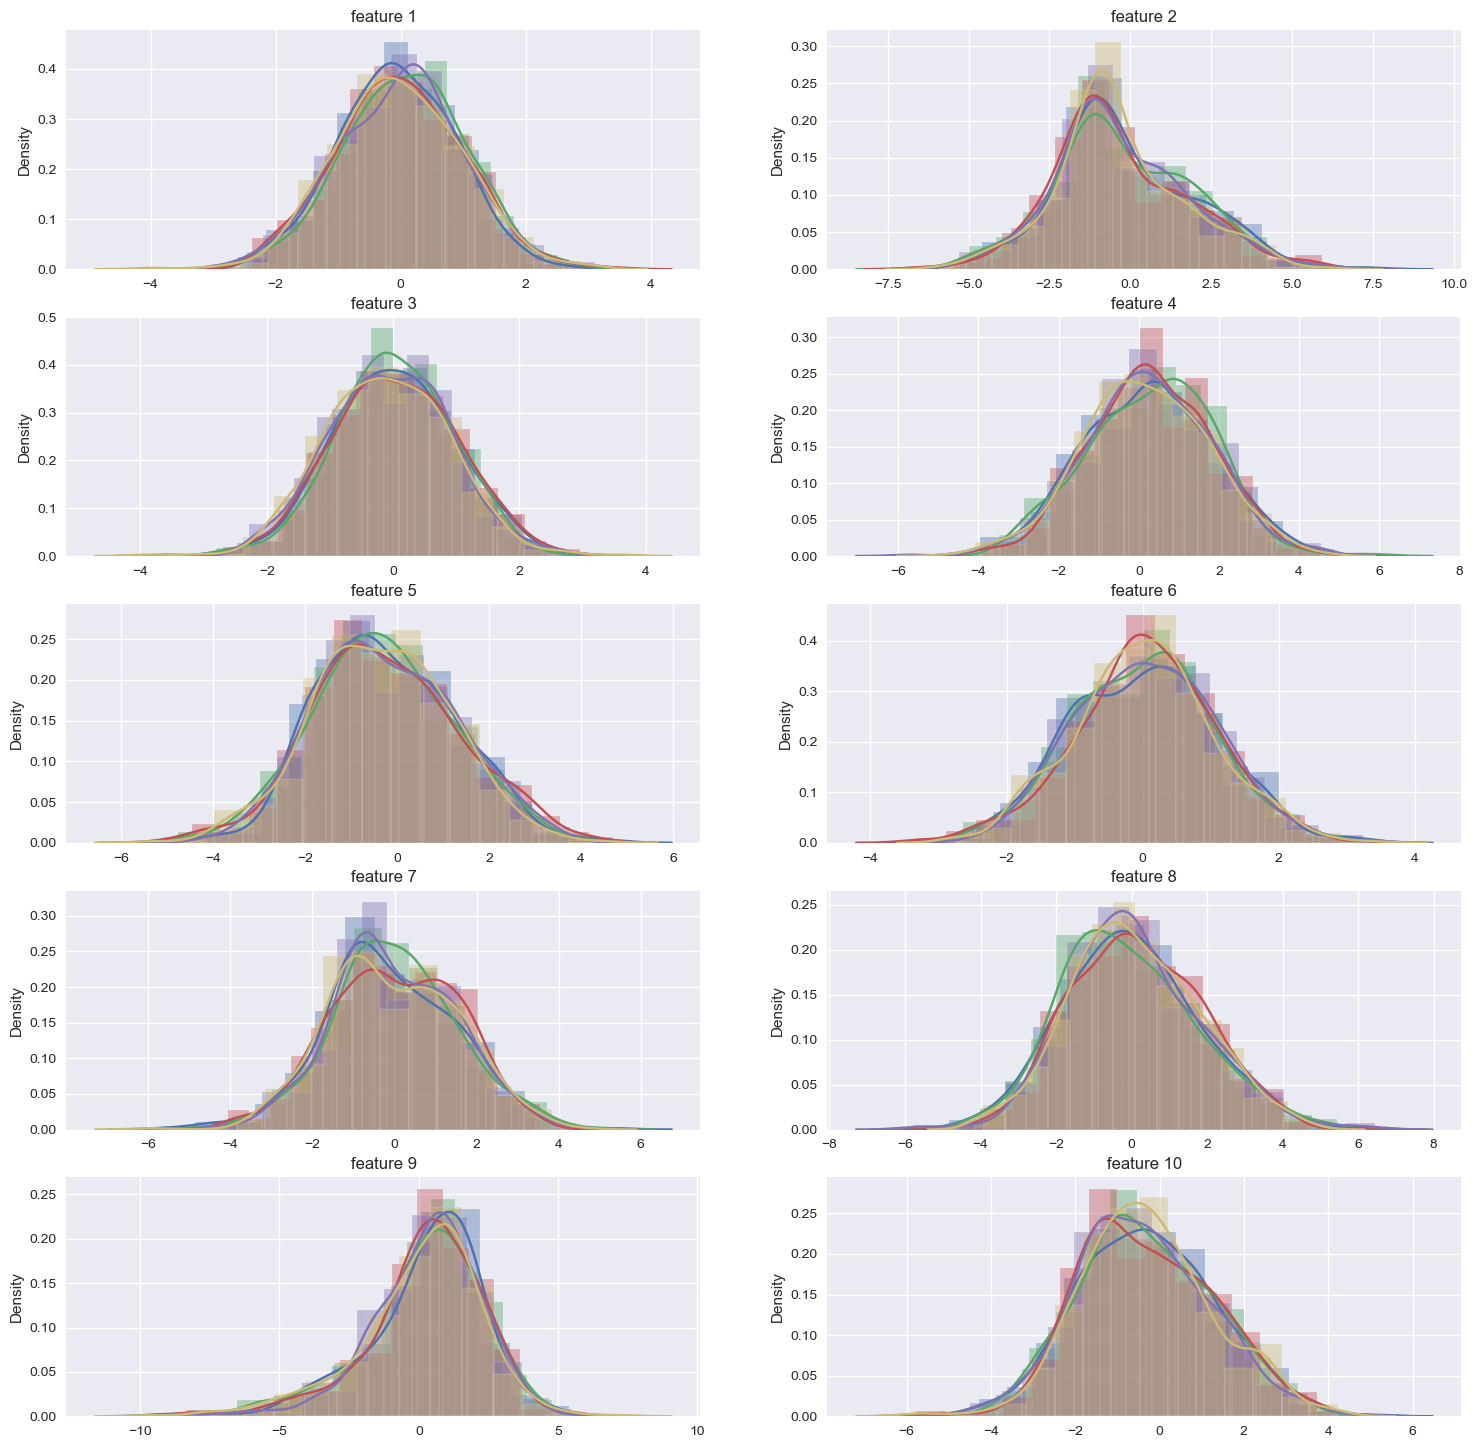

In [77]:
plt.style.use('seaborn')  
fig,axes = plt.subplots(ncols=2,nrows=5,figsize=[18,18]) 
RSP_sample = random.sample(list(range(x.shape[1])),5) 
for i,ax_ in enumerate(axes.flat[:10]):  
    ax_.set_title('feature '+str(i+1))  
    # RSP  
    for j in RSP_sample:
        sns.distplot(RSP[j,:,i],kde=True,ax=ax_,bins=15) # 分块  


# 模型训练

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from copy import deepcopy

In [10]:

def plot_learningCurve_(pipes, X_train, y_train, X_test, y_test, train_sizes = 4):
    """
    绘制学习曲线图
    """
    train_score_list = []
    test_score_list = []
    nums_list = []
    for rate in np.linspace(0.05, 1, train_sizes):
        nums = int(X_train.shape[0]*rate)
        nums_list.append(nums)
        train_data = X_train[:nums,:]
        test_data = y_train[:nums,:]
        pipes.fit(train_data, test_data)
        # train
        train_score = cross_val_score(pipes, train_data, test_data, cv = 10)
        train_score_list.append(train_score)
        # test
        test_score = pipes.score(X_test, y_test)
        test_score_list.append(test_score)

    train_scores = np.array(train_score_list)
    test_scores = np.array(test_score_list)
    train_mean= np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    # test_mean =np.mean(test_scores,axis=1)
    # test_std=np.std(test_scores,axis=1)
    #绘制效果
    # train
    plt.figure(figsize=[12,8])
    plt.plot(nums_list,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
    plt.fill_between(nums_list,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
    # test
    plt.plot(nums_list,test_scores,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(pipes['clf'].__class__.__name__)
    plt.show()

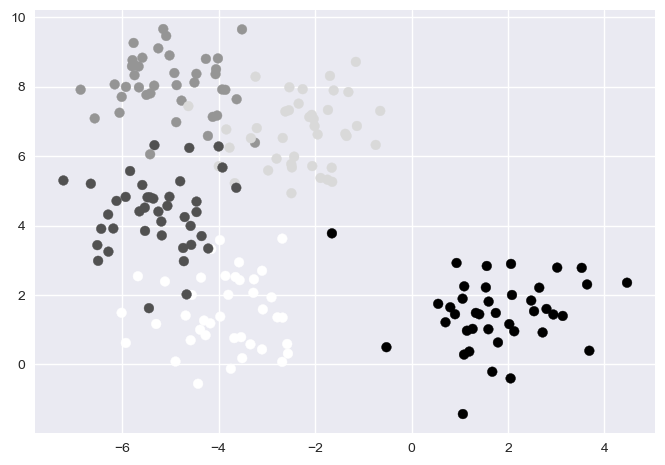

10
[2 2 0 0 2 1 3 1 0 0 1 2 2 3 2 1 1 0 0 0 3 0 3 1 2 0 1 0 0 1 3 2 2 2 1 2 1
 2 0 2 2 0 0 2 3 1 2 2 3 0 1 3 0 0 3 1 1 1 3 0 0 0 1 3 2 3 3 0 0 3 3 3 2 3
 0 0 3 2 2 3 1 1 0 1 0 0 0 2 2 2 0 0 0 0 0 2 1 1 1 0 3 2 3 0 1 3 2 2 0 0 3
 2 3 0 1 2 3 3 0 0 0 1 1 0 1 3 2 3 2 2 3 2 3 0 0 0 0 2 2 2 0 1 1 3 2 2 1 1
 0 0 1 1 3 3 2 1 3 1 3 0 3 3 2 2 1 0 0 3 0 2 1 2 0 0 0 2 3 2 3 3 0 1 2 2 0
 2 1 0 1 2 0 2 0 2 1 3 1 2 0 1 0 2 2 0 3 0 1 2 0 1 2 3 2 0 3 0 3 2 2 2 2 2
 3 3 0 0 1 2 1 3 0 3 0 1 0 1 1 3 3 0 1 2 3 1 2 1 2 0 1 3 3 3 1 0 3 0 0 0 3
 1 3 1 1 0 0 3 2 1 1 1 3 2 1 0 1 3 1 0 3 0 3 2 3 1 0 2 3 1 2 2 1 2 2 0 0 0
 0 1 0 1 3 2 3 2 3 3 2 1 2 1 2 0 2 0 3 3 3 2 3 3 3 3 0 2 0 0 1 1 1 1 1 2 1
 2 0 3 3 2 0 0 3 1 0 2 2 1 1 3 1 0 0 0 0 1 2 3 3 3 3 1 1 2 1 1 1 1 3 1 0 1
 3 3 2 0 3 2 3 0 3 1 0 2 1 3 0 0 1 2 2 0 3 1 1 3 0 0 2 0 1 2 0 0 1 3 3 2 0
 3 1 2 1 0 1 0 0 2 3 3 2 3 1 1 1 1 1 1 3 0 2 3 2 1 2 2 0 3 3 2 1 0 0 3 2 3
 0 3 1 0 0 1 0 2 3 2 0 2 3 0 3 1 2 3 0 0 1 2 0 2 0 1 1 3 3 1 0 0 0 2 2 2 1
 2 0 1 1 0 2 2 1 3 3 3